<div align=right>Luzius Meisser, Marlon Azonivic, November 2016</div>
<div align=right>Mathematical Finance Course, Prof. Marc Chesney</div>

<h1 align=center>Leverage Causes Fat Tails and Clustered Volatility</h1>

<h2>1. Introduction</h2>

This is an implementation of the leveraged trading model described in the 2013 paper <a href="http://www.uvm.edu/~cmplxsys/legacy/newsevents/pdfs/2013/thurner-volatility-finance.pdf"><em>Leverage Causes Fat Tails and Clustered Volatility</em></a> by Thurner, Farmer and Geanakoplos.

The model consists of three agent types. First, there is a noise trader that buys and sells stocks every day without much of a plan. On its own, it generates a mean-reverting random walk like the green one shown in the chart below.
<img src="files/intuition.png">
Second, there are a number of leveraged funds following a value strategy. They buy stocks when they are below the fundamental value and sell them again when they rise back above it. Their buying prevents prices from falling significantly below the fundamental value, thereby dampening volatility. However, being leveraged, these funds might be forced to sell if prices fall too much, thereby quickly driving prices even lower. This causes the fat tail event shown in the chart above. The funds go bankrupt and the price falls to where it would be without them. After such a crash, it takes some time until the funds recover. These are periods (clusters) with higher volatility than before.

Third, there are background investors that rebalance their investments between the funds. Their main purpose is to withdraw money from the funds in order to prevent them from getting unboundedly rich.

<h2>2. The Noise Trader</h2>
The behavior of the noise trader is modeled around the <em>cash value</em> $\xi_{nt}(t)$ the trader has invested in the stock market at time $t$. It is specified such that it follows the autoregressive random process described by equation 1. In absence of other traders, it makes the price $p(t)$ follow a mean-reverting random walk.

\begin{align}
    log(\xi_{nt}(t)) = \rho~log(\xi_{nt}(t-1)) + \sigma \chi(t) + (1-\rho)log(NV) \tag{1}
\end{align}    

Parameters $\rho=0.99$ and $\sigma=0.035$ are constant, with $\chi(t)\sim\mathcal{N}(0, 1)$ being a standard-normal random variable. The <em>fundamental value</em> $V$ of each of the $N=1000$ shares is constant with $V=1$. Thus, $NV$ represents the total fundamental value of the stock market and the anchor for the mean-reversion. In absence of other traders, the expected logarithmic amount the noise trader has invested in the stock market matches the logarithmic fundamental value:

\begin{align}
    E[log(\xi_{nt})] = log(NV)
\end{align}

Market clearing further dictates $\xi_{nt}=Np$ and therefore $E[log(p)] = log(V)$ for the price of a single share.

As a first step, we will simulate the noise trader in isolation to get a more intuitive understanding of its behavior and the resulting prices.

In [1]:
# load and configure required modules
%load_ext autoreload
%autoreload 2

import math
import numpy # numerics
import scipy
from scipy import optimize # we use their root finding algorithm
import matplotlib.pyplot as plot
%matplotlib inline

In [29]:
#Constants
N = 1000 # number of shares
V = 1    # fundamental value per share
RANDOM_SEED = 13 # change to get a different outcome

# Function for noise trader's investment given the previous value (equation 1)
default_rho = 0.99
sigma = 0.035

def calculateNoiseTraderInvestment(previousInvestment):
    return calculateNoiseTraderInvestment2(previousInvestment, default_rho)

def calculateNoiseTraderInvestment2(previousInvestment, rho):
    return math.exp(rho * math.log(previousInvestment) + sigma * numpy.random.normal() + (1-rho)*math.log(N*V))

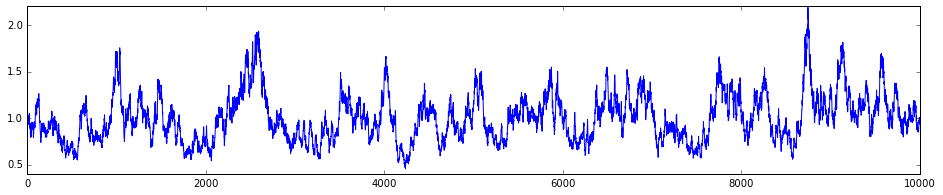

In [3]:
# Create and plot price time series
def createNoiseTraderTimeSeries(length, rho):
    numpy.random.seed(RANDOM_SEED)
    investment = N*V # start value
    prices = [investment / N]
    while len(prices) < length:
        investment = calculateNoiseTraderInvestment2(investment, rho)
        prices.append(investment / N)
    return prices

plot.figure(figsize=(16,3))
noiseResult = createNoiseTraderTimeSeries(10000, default_rho)
plot.plot(noiseResult)
plot.show()

<h2>3. Investment Funds</h2>
<h3>3.1 Specification</h3>
As a next step, investment funds following a value strategy are added to the model. Each fund $h$ has wealth $W_h(t) = \xi_h(t) + C_h(t)$, consisting of a stock market investment $\xi_h$ and cash $C_h$. Cash can be negative when the fund is leveraged. All funds base their decisions on the same mispricing signal

\begin{align}
    m(t) = V - p(t) \tag{2}
\end{align}

whereas a positive $m(t)$ signals that the stock market is undervalued. As long as the market is overvalued (i.e. $m(t) \leq 0$), the funds do not hold any stocks. However, as soon as an undervaluation is detected, funds demand $\xi_h(t)$ worth of stocks, which depends on the magnitude of the signal as well as the fund's wealth:

\begin{align}
    \xi_h(t) = min\big(~\beta_h m(t),~\lambda_{MAX}\big)~W_h(t) \tag{3}
\end{align}

The maximum leverage is set to $\lambda_{MAX}=20$. This sounds high, but can be justified when considering that European bank leverage currently stands at about 30 (source: <a href=http://www.marathonfund.com/>Marathon Asset Management</a>, Global Investment Review, Volume 30 No 1). A deeper investigation on how different values of $\lambda_{MAX}$ affect the results can be found in the original paper, but is skipped here. The parameter $\beta_h$ varies between funds and specifies how aggressively a fund responds to the buy signal. There are 10 funds with $5\leq\beta_h\leq50$.

It is key to understand that the investment $\xi_h(t)$ of a fund depends not only of the signal, but indirectly through wealth also on current prices. Once a fund is fully leveraged, a further decline of $p(t)$ can lead to a decreased investment $\xi_h(t)$ despite the signal $m(t)$ getting stronger, simply because the fund does not have the necessary wealth any more.


In [4]:
class Fund:
    
    initialWealth = 2 # named beta in the equation-based version of the model
    maxLeverage = 20  # named lambda_max in the equation-based version of the model
    
    def __init__(self, aggressiveness):
        self.aggressiveness = aggressiveness
        self.cash = self.initialWealth  # W_h(0) in the equation-based model
        self.shares = 0
        self.activationDelay = 0
             
    def checkBankrupt(self, price):
        if self.isActive():
            # check for bankrupty
            if self.getWealth(price) <= self.initialWealth * 0.1:
                self.shares = 0
                self.cash = self.initialWealth
                self.activationDelay = 100 # the fund is bankrupt and will resurrect in 100 days
                return True
            else:
                return False
        else: 
            self.activationDelay = self.activationDelay - 1
            return False
            
    def processInflows(self, oldprice, newprice): # used later
        return
        
    # returns true if the fund is not bankrupt
    def isActive(self):
        return self.activationDelay == 0;
    
    def getWealth(self, price): 
        return max(0, self.cash + self.shares * price);
    
    # returns the number of shares the fund would like to hold at the given price
    def getDemand(self, price):
        if self.isActive():
            m = V - price # equation 2
            if (m < 0):
                return 0
            
            # equation 3 divided by price
            leverage = min(self.aggressiveness * m, self.maxLeverage)
            return leverage * self.getWealth(price) / price
        else:
            return 0
    
    # updates the fund's holdings by trading at the given price
    def trade(self, price):
        if self.isActive():
            wealth = self.getWealth(price)
            self.shares = self.getDemand(price)
            self.cash = wealth - self.shares * price

<h3>3.2 Test</h3>

Having defined a fund class, let us test it by reproducing figure 1 from the paper, but with price $p$ on the x-axis instead of signal $m$ and default parameters. The y-axis shows investment $\xi_h$. The figure illustrates how much a fund with wealth $W_h=2$, $\beta_h=50$ and maximum leverage $\lambda_{max}=20$ would like to invest. As expected $\xi_h \leq W_h \lambda_{max} = 40$ for all prices.

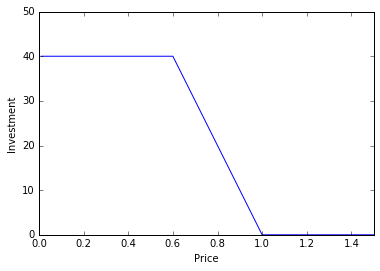

In [5]:
testFund = Fund(50)

prices = []
demand = []
for i in range(-99, 100):
    price = V + i / 100
    investment = testFund.getDemand(price) * price
    prices.append(price)
    demand.append(investment)
    
plot.xlabel('Price')
plot.ylabel('Investment')
plot.axis([0.0, 1.5, 0, 50])
plot.plot(prices, demand)
plot.show()

<h2>4. Market Clearing</h2>
Market clearing dictates that supply must match demand:

\begin{align}
    \xi_{nt}(t) + \sum_h \xi_h(t, p(t)) = Np(t) \tag{4}
\end{align}

Total investments must match market capitalization.


In [6]:
minPrice = 0.01
maxPrice = 5

# Rearranged equation 4
def calculateExcessDemand(noiseTraderInvestment, funds, price):
    demand = noiseTraderInvestment / price
    for f in funds:
        demand = demand + f.getDemand(price)
    return demand - N
        
def findEquilibrium(noiseTraderInvestment, funds):
    # The scipy solver wants an univariate function, so we create a temporary demand function 
    # that only depends on p, with the other two parameters staying constant
    currentExcessDemandFunction = lambda p : calculateExcessDemand(noiseTraderInvestment, funds, p)
    return scipy.optimize.brentq(currentExcessDemandFunction, minPrice, maxPrice)

<h2>5. Running the Simulation</h2>

<h3>5.1 Noise Trader and Funds</h3>
Before moving on to the background investor, let us test what the stock market looks like in a world consisting of only noise traders and funds.

In [7]:
def initializeFunds(fundType):
    funds = []
    Fund.maxLeverage = 50
    for beta in range(1, 11):
        funds.append(fundType(beta * 5))
    return funds

In [8]:
def simulate(time, fundType):
    numpy.random.seed(RANDOM_SEED)
    funds = initializeFunds(fundType)
    days = range(1, time)
    oldprice = 1
    prices = [oldprice]
    noiseTraderInvestment = 1000
    noiseTraderPrices = [noiseTraderInvestment/N]
    fundWealth = []
    for day in days:
        noiseTraderInvestment = calculateNoiseTraderInvestment(noiseTraderInvestment)
        newprice = findEquilibrium(noiseTraderInvestment, funds)
        currentWealth = []
        for f in funds:
            f.trade(newprice)
            f.checkBankrupt(newprice)
            f.processInflows(oldprice, newprice)
            currentWealth.append(f.getWealth(newprice))
           
        prices.append(newprice)
        oldprice = newprice
        noiseTraderPrice = min(noiseTraderInvestment/N, maxPrice)
    
        noiseTraderPrices.append(noiseTraderPrice)
        fundWealth.append(currentWealth)
    return {'days': [0] + list(days), 'prices':prices, 'noiseP':noiseTraderPrices, 'wealth':fundWealth}

In [9]:
def plotResult(result, start=0, end=-1):
    if (end == -1):
        end = len(result['days'])
    plot.figure(figsize=(16,4))
    plot.plot(result['days'], result['prices'], 'b', label='including funds')
    plot.plot(result['days'], result['noiseP'], 'g', label='noise trader only')
    plot.xlabel('Day')
    plot.ylabel('Price')
    plot.legend(loc='upper left')
    plot.axis([start, end, 0, 2])
    plot.show()

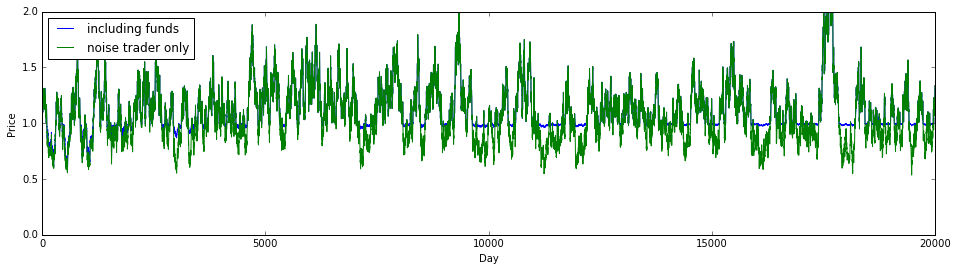

In [47]:
fundResult = simulate(20000, Fund)
plotResult(fundResult)

With the funds investing at undervalued prices, the prices do not fall much below the fundamental value. 

As a side effect of following a value stategy, the funds accumulate wealth over time, as the following plot shows.

<h3>5.2 Adding the Background Investor</h3>
Investors invest or disinvest from each fund based on its recent performance $r_h^{perf}(t)$, which is based on a moving average of recent returns $r(t)$, with $a=0.1$:

\begin{align}
    r_h^{perf}(t) = (1-a)~r_h^{perf}(t-1)+a~r_h(t) \tag{5}
\end{align}

\begin{align}
    r(t) = \frac{(\frac{p(t)}{p(t-1)} - 1)~\xi_{h}(t-1))}{W_h(t-1)}
\end{align}

The flow of capital in or out of the fund $F_h(t)$:

\begin{align}
F_h(t) = max\big(\text{-}1,~b~(r_h^{perf}(t) - r^b)\big)~W_h(t) \tag{7}
\end{align}

with $r^b = 0.005$ being a benchmark return and $b = 0.15$ being a sensitivity parameter. The benchmark return can be used to tune how wealthy the funds can grow. With a higher benchmark return, profits are withdrawn sooner and the asymptotic fund size smaller.







In [11]:
# DynamicFund extends Fund by adding inflow/outflow dynamics
class DynamicFund(Fund):
    
    benchmarkPerformance = 0.005 # r^b
    sensitivity = 0.10 # b, original paper uses 0.15, but 0.10 looks more interesting to me
        
    def __init__(self, aggressiveness):
        super(DynamicFund, self).__init__(aggressiveness)
        self.performance = 0.0
        self.previousWealth = self.initialWealth
        self.previousInvestment = 0.0
        
    def updatePerformance(self, oldprice, newprice, wealth):
        ret = (newprice/oldprice - 1)*self.previousInvestment/self.previousWealth
        self.performance = 0.9 * self.performance + 0.1 * ret # equation 5
        # remember values for next round
        self.previousInvestment = self.shares * newprice
        self.previousWealth = wealth
        return self.performance
    
    def processInflows(self, oldprice, newprice):
        if self.isActive():
            wealth = self.getWealth(newprice)
            perf = self.updatePerformance(oldprice, newprice, wealth)
            inflow = self.sensitivity*(perf - self.benchmarkPerformance)*wealth
            self.cash += max(inflow, -wealth)
        
        

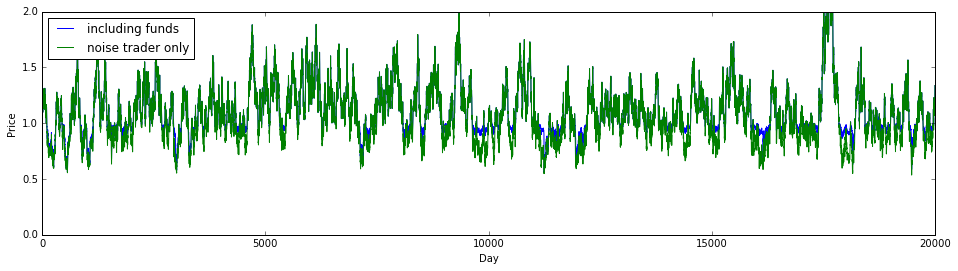

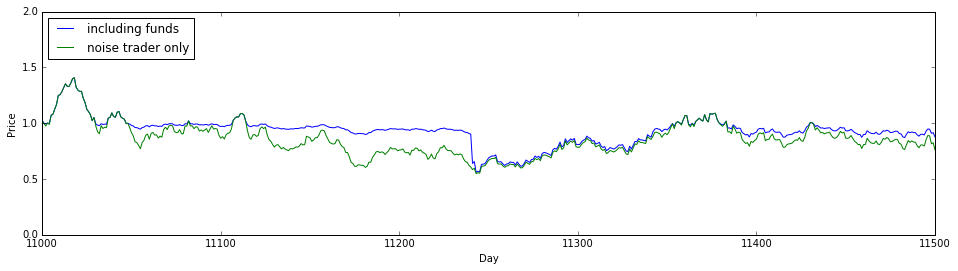

In [46]:
rebalanceResult = simulate(20000, DynamicFund)
plotResult(rebalanceResult)
plotResult(rebalanceResult, 11000, 11500)

<h3> 5.3 Replacing the Background Investor with a Wealth Tax </h3>

The authors of the original paper say about the background investor: "We introduced this into our model because it guarantees a steady-state behavior, with welldefined long-term statistical averages. Without this the wealth of the funds grows without bound, since the funds consistently profit at the expense of the noise traders. [...] Since the wealth dynamics we have chosen is a form of trend following, it unfortunately introduces some confusion about the source of the heavy tails that we observe here. As we explain later, based on various experiments we are confident that the wealth dynamics of the investors is not the source of the heavy tails."

To verify this claim, let us create a simpler version of the DynamicFund, namely a TaxedFund that pays a daily tax of 0.003% of its wealth.

In [42]:
# TaxedFund pays a wealth tax
class TaxedFund(Fund):
       
    def processInflows(self, oldprice, newprice):
        if self.isActive():
            wealth = self.getWealth(newprice)
            self.cash -= 0.0004*wealth
        

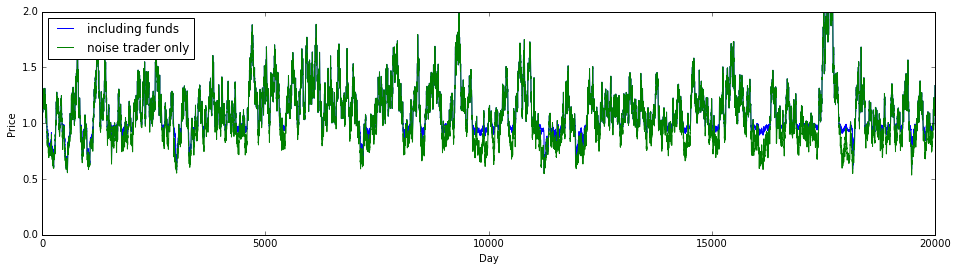

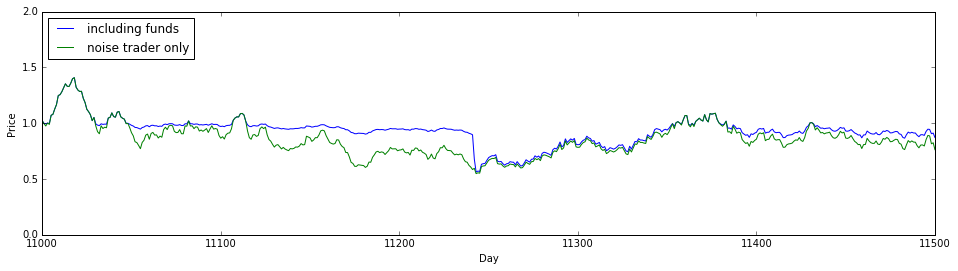

In [44]:
taxedResult = simulate(20000, TaxedFund)
plotResult(taxedResult) # full plot
plotResult(taxedResult, 11000, 11500)

<h3> Statistics </h3>

Comparing some basic statistics of the four time series. This is just a proof of concept and could be done more professionally. Also, skewness and kurtosis are not accurate at all as they are heavily influenced by single outliers.

In [15]:
def calculateLogReturn(x, y):
    return math.log(x/y)

def calculateLogReturns(prices):
    length = len(prices)
    return list(map(calculateLogReturn, prices[int(length/5):length-1], prices[int(length/5)+1:length]))

In [16]:
def calculateMoment(moment, points):
    size = len(points)
    total = 0
    for p in points:
        total += p ** moment
    return total / size
    
def calculateMean(points):
    return calculateMoment(1, points)

# biased estimator ?
def calculateVariance(points):
    m1 = calculateMoment(1, points)
    m2 = calculateMoment(2, points)
    return m2 - m1*m1

# biased estimator ?
def calculateSkewness(points):
    m1 = calculateMoment(1, points)
    m2 = calculateMoment(2, points)
    m3 = calculateMoment(3, points)
    return (m3 - 3*m1*m2 + m1**3)/(m2*math.sqrt(m2))

# biased estimator ?
def calculateKurtosis(points):
    m1 = calculateMoment(1, points)
    m2 = calculateMoment(2, points)
    m3 = calculateMoment(3, points)
    m4 = calculateMoment(4, points)
    return (m4 - 3*m1*m3 - m1*m1*m2 - 3*(m1**4))/(m2*m2)

def stats(points):
    points = calculateLogReturns(points)
    return {'mean': calculateMean(points), 'variance': calculateVariance(points),
        'skewness':calculateSkewness(points), 'kurtosis': calculateKurtosis(points)}
    

In [17]:
{'random walk': stats(createNoiseTraderTimeSeries(50000, 1.0)),
 'noise only': stats(createNoiseTraderTimeSeries(50000, default_rho)),
 'plain funds': stats(simulate(50000, Fund)['prices']),
 'dynamic funds': stats(simulate(50000, DynamicFund)['prices']),
'taxed funds': stats(simulate(50000, TaxedFund)['prices'])}

{'dynamic funds': {'kurtosis': 18.63667657602553,
  'mean': 1.0974666027596164e-05,
  'skewness': 0.6732126541639886,
  'variance': 0.0007830627902350294},
 'noise only': {'kurtosis': 3.002104164152716,
  'mean': 1.1728284177266956e-05,
  'skewness': 0.013587332719749809,
  'variance': 0.001216787638239312},
 'plain funds': {'kurtosis': 6.0227251876887005,
  'mean': 1.5788159979420052e-07,
  'skewness': 0.03863073275747494,
  'variance': 0.0005945523628872469},
 'random walk': {'kurtosis': 2.9988696690603884,
  'mean': 0.00010539295213711142,
  'skewness': 0.011323945222029234,
  'variance': 0.0012104868322432138},
 'taxed funds': {'kurtosis': 9.771212529263376,
  'mean': 1.0120759632714703e-05,
  'skewness': 0.4235477210640974,
  'variance': 0.0007235816746978138}}